# Seasonality in Modeling (SARIMA)

- So far no models have taken seasonality into account.
- Data often does have seasonality, which must be taken into account.
- SARIMA's are essentially 2 ARIMA models combined
    - An ARIMA model (p,d,q) which calculates coeffs for each lag using the raw freq of data
    - An ARIMA model (P,D,Q) which calculates coeffs for each season using the seasonal freq of the data
- The letter 'm' is used to indicate season length.
    - For example if a season in data is 7 days, m=7
    - If working with monthly data anda trend occurs yearly, m=12

### Imports, Loading, Preparation

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)

sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

#### Custom Functions

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

#### Loading and Preparing data

In [8]:
# Load data from statsmodels
import statsmodels.api as sm
co2_data = sm.datasets.co2.load_pandas()
df = co2_data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [9]:
# Impute null values
df['co2'] = df['co2'].interpolate()
df.isna().sum().sum()

0

In [10]:
# Resample to monthly
ts = df.resample("M").mean()
ts.head()

,co2
1958-03-31,316.100
1958-04-30,317.200
1958-05-31,317.410
1958-06-30,316.675
1958-07-31,315.625


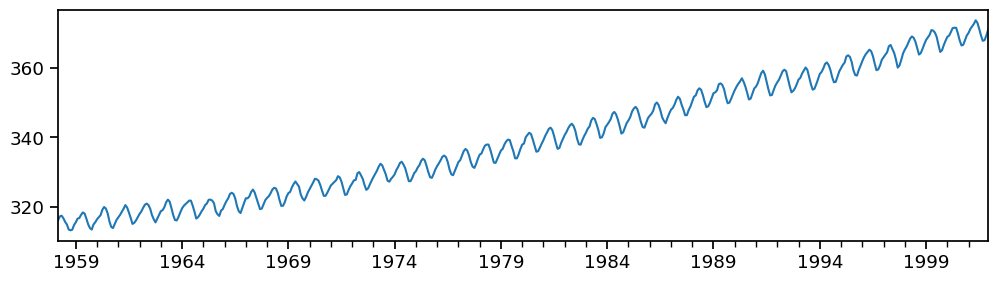

In [11]:
# Define the series
ts = ts['co2']
# Plot
ts.plot();

- The data has a repeating pattern that may indicate seasonality.
- Do EDA to confirm. Make use of seasonal decomposition to view three parts:
    - Overall trend/drift
    - Large seasonal component
    - Remaining fluctoations (residuals)

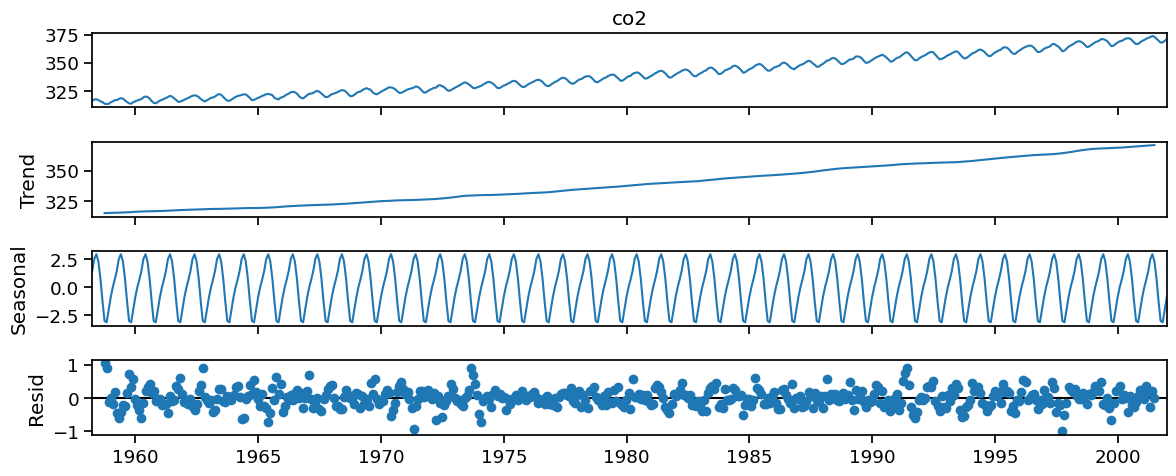

In [12]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

- Seasonal decompose will always indicate some seasonality, it must be considered how impactful it actually is.

In [16]:
# Examine seasonal component size
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is seasonal component relative to time series?
print(f'The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min())* 100 :.2f}% of the variation in time series.')

The seasonal component is 6.0652410580715355 which is ~10.01% of the variation in time series.


- Next determine the period of the season. This is easier when 'zoomed in' on the seasonal plot by narrowing down the range of dates we display. We will arbitrarily choose a few years from 1975 to 1978.
- Also indicate points on the plot using marker 'o'

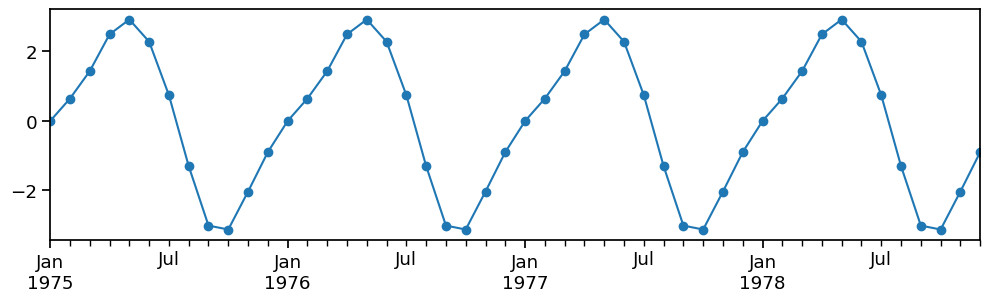

In [17]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['1975':'1978'].plot(marker='o')

- There are 12 points between peaks indicating a seasonal period of 12 months.
- This makes sense with CO2 data. This model is appropriate for using a seasonal model.

### SARIMA

- The SARIMA model is very similar to ARIMA but must also have a defined seasonal_orer, which is represented as (P, D, Q, m) or sometimes (P, D, Q)[m]
- Model will now have both sets of orders: SARIMA(p,d,q)(P,D,Q)[m]
- In addition to determining nonseasonal p, d, q as for ARIMA models, the number of seasonal AR components (P), amount of seasonal differencing (D), and seasonal MA components (Q) must be determined.
    - Notice the lowercase use for non-seasonal and uppercase for seasonal. m is the seasonal period.

#### Stationarity

- Both seasonal and nonseasonal models require stationary data. Start by checking data for stationarity and determining differencing. With seasonal data, there are two types of differencing to consider:
    - d for regular differencing (subtract one lag)
    - D for seasonal differencing (subtract m lags)
- NOTE: should only have 2 or fewer differencings ((d + D) <= 2)  

In [18]:
# Determine d
d = ndiffs(ts)
print(f'd = {d}')

d = 1


In [19]:
## nsdiffs() can be used to determine the number of seasonal differencings.
## A value for m must be included.
# Determine D
D = nsdiffs(ts, m=12)
print(f'D = {D}')

D = 0


- In this case seasonal differencing is not needed. However to apply seasonal differencing, the code would be similar to nonseasonal differencing but the period is included with .diff().
    - ts_diff = ts.diff(2)
- In this case, apply one nonseasonal differencing. Another options to try a model where seasonal differencing is applied instead of regular differencing.
- Determining model orders is not an exact process.

In [20]:
# Difference the data
ts_diff = ts.diff().dropna()

#### Estimating Orders from ACF/PACF Plots

- With this new seasonal model, it's possible to take advantage of 'annotate_seas' argument when calling the custom func plat_acf_pacf. This requires indicating the seasonal period (here m=12).

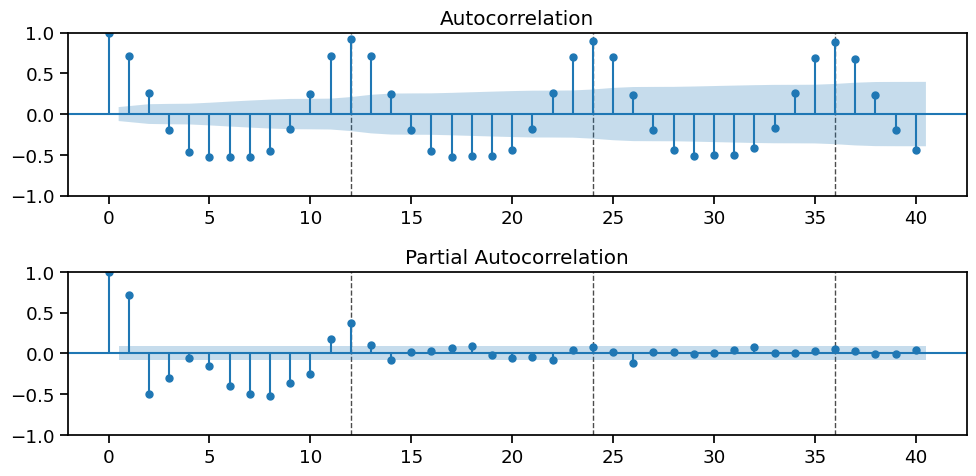

In [22]:
# Can use custom func to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts_diff, annotate_seas=True, m=12);

**p and q**
- Use these plots to determine p and q, just as with nonseasonal models.
- For this, determine if the decrease is gradual or a notable dropoff.
- Here, it appears both ACF and PACF gradually decrease in magnitude, so start with ARMA. Specifically, AR(1) and MA(1).

**P and Q**
- For seasonal orders, only look at seasonal lags (annotated in each plot).
- In this case, the plot shows 3 seasonal lags. It's possible to see more seasonal lags by using the nlags argument in the plot function.
- *Ignoring the rest of the lags,* focus on the seasonal lags and apply the same basic guidelines for determining p and q.
- Seasonal lags in the PACF show a gradual decrease, and seasonal lags in ACF stay consistently high, so start with seasonal-AR, SAR(1), and a seasonal-MA, SMA(1).
- Note that obtaining the orders from ACF/PACF plots is just a starting point. Variations of the model must be considered before deciding on a final model.
- The starting point here is (1,1,1)(1,0,1)[12]

#### Train Test Split

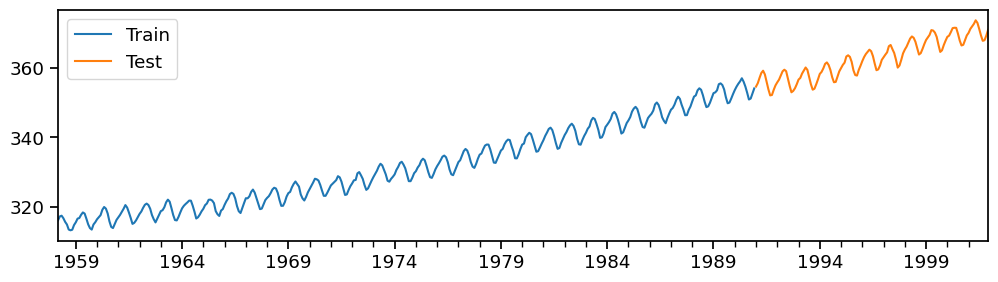

In [23]:
# tts
train, test = train_test_split(ts, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

**Fitting a SARIMA model**

- Building a seasonal model is very similar to a nonseasonal model, the difference being the seasonal orders must also be specified.

In [24]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.795
- MSE = 0.952
- RMSE = 0.976
- R^2 = 0.969
- MAPE = 0.22%


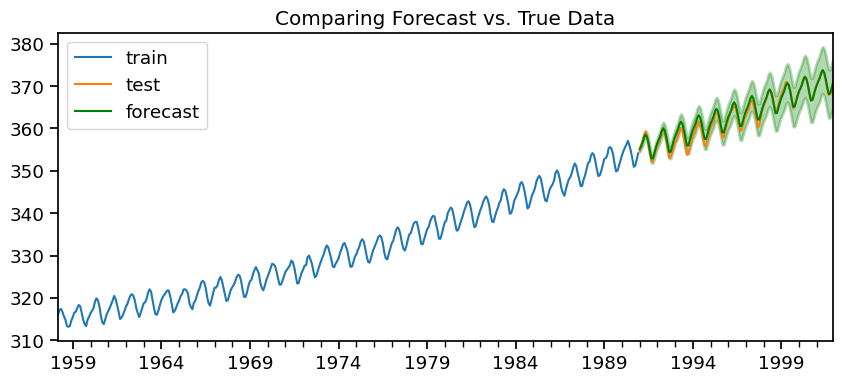

In [25]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

- The model looks to be performing well. MAPE is below 1% and the forecast closely overlaps the test data.
- Next check model summary and plot diagnostics.

In [26]:
# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                              co2   No. Observations:                  394
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -107.968
Date:                          Wed, 06 Dec 2023   AIC                            225.935
Time:                                  16:36:05   BIC                            245.804
Sample:                              03-31-1958   HQIC                           233.809
                                   - 12-31-1990                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4094      0.094      4.376      0.000       0.226       0.593
ma.L1         -0.7159      0.074     -9.638      0.000      -0.862      -0.570
ar.S.L12       0.9995      0.000   2048.798      0.000       0.999       1.000
ma.S.L12      -0.8581      0.034    -25.201      0.000      -0.925      -0.791
sigma2         0.0886      0.006     13.800      0.000       0.076       0.101
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.56   Prob(JB):                         0.98
Heteroskedasticity (H):               0.82   Skew:                            -0.00
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Notice seasonal coeffs include 'S', for example 'ar.S.L12' for the seasonal P=1 and 'ma.S.L12' for the seasonal Q=1. The 'L' is the lag, with L12 indicating a seasonal period of 12.

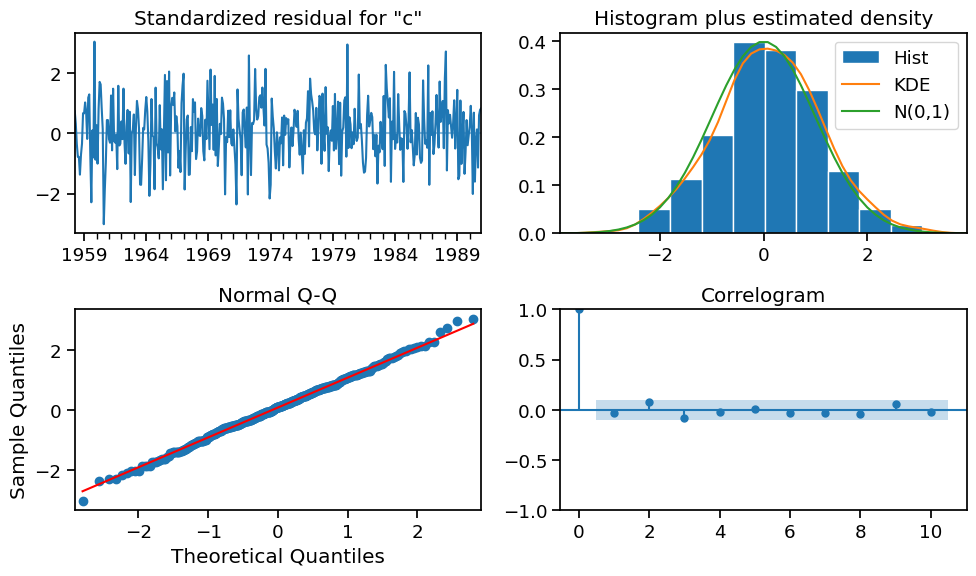

In [27]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

- The diagnostic plots look pretty good. Possible significant value at lag 3, but otherwise solid starting point.

#### Loop through variations

In [28]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [1]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12),
 (0, 1, 0, 2, 0, 2, 12),
 (0, 1, 1, 0, 0, 0, 12)]

- Some combinations will cause an error, so to speed up the process try and except clauses are added to allow the loop to continue working if it encounters an error.

In [29]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

(0, 1, 0, 0, 0, 0, 12) 1229.8364886351249
(0, 1, 0, 0, 0, 1, 12) 913.922286884557
(0, 1, 0, 0, 0, 2, 12) 762.7178747740488
(0, 1, 0, 1, 0, 0, 12) 437.78554186024303
(0, 1, 0, 1, 0, 1, 12) 260.6325978648941
(0, 1, 0, 1, 0, 2, 12) 262.5249388459649
(0, 1, 0, 2, 0, 0, 12) 363.07061562745105
(0, 1, 0, 2, 0, 1, 12) 262.53606993957135
(0, 1, 0, 2, 0, 2, 12) 263.2360679021916
(0, 1, 1, 0, 0, 0, 12) 998.8592636685013
(0, 1, 1, 0, 0, 1, 12) 824.8423373069064
(0, 1, 1, 0, 0, 2, 12) 734.2342957156474
(0, 1, 1, 1, 0, 0, 12) 405.79983490616496
(0, 1, 1, 1, 0, 1, 12) 231.70575152742606
(0, 1, 1, 1, 0, 2, 12) 233.7025042398264
(0, 1, 1, 2, 0, 0, 12) 331.7022152829562
(0, 1, 1, 2, 0, 1, 12) 233.7006016480349


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1, 2, 0, 2, 12) 234.36724343475112
(0, 1, 2, 0, 0, 0, 12) 894.5771694837315
(0, 1, 2, 0, 0, 1, 12) 758.1609034856353
(0, 1, 2, 0, 0, 2, 12) 683.0718561804333
(0, 1, 2, 1, 0, 0, 12) 405.3915541920906


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2, 1, 0, 1, 12) 230.1886569711699
(0, 1, 2, 1, 0, 2, 12) 232.19461734557518
(0, 1, 2, 2, 0, 0, 12) 330.54898104139295
(0, 1, 2, 2, 0, 1, 12) 232.18793878485818
(0, 1, 2, 2, 0, 2, 12) 232.72259012961513
(1, 1, 0, 0, 0, 0, 12) 959.4686407432031
(1, 1, 0, 0, 0, 1, 12) 787.6071484403733
(1, 1, 0, 0, 0, 2, 12) 714.4686198820909
(1, 1, 0, 1, 0, 0, 12) 410.5616322299469
(1, 1, 0, 1, 0, 1, 12) 237.15058581394652
(1, 1, 0, 1, 0, 2, 12) 239.08900420867712
(1, 1, 0, 2, 0, 0, 12) 336.8667112063631
(1, 1, 0, 2, 0, 1, 12) 239.09798732928186
(1, 1, 0, 2, 0, 2, 12) 239.96443918937356
(1, 1, 1, 0, 0, 0, 12) 912.4263291223896
(1, 1, 1, 0, 0, 1, 12) 785.2711621754609
(1, 1, 1, 0, 0, 2, 12) 716.3249350504028
(1, 1, 1, 1, 0, 0, 12) 401.25154361976735
(1, 1, 1, 1, 0, 1, 12) 225.93526624061144


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 2, 12) 227.94109940196412
(1, 1, 1, 2, 0, 0, 12) 326.7792656468158
(1, 1, 1, 2, 0, 1, 12) 227.94343867387713
(1, 1, 1, 2, 0, 2, 12) 228.52889563924
(1, 1, 2, 0, 0, 0, 12) 869.8756728421206
(1, 1, 2, 0, 0, 1, 12) 752.3192682392155
(1, 1, 2, 0, 0, 2, 12) 684.0614469071885
(1, 1, 2, 1, 0, 0, 12) 391.50135934358764
(1, 1, 2, 1, 0, 1, 12): caused an error
(1, 1, 2, 1, 0, 2, 12): caused an error
(1, 1, 2, 2, 0, 0, 12) 322.1600277594175


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 1, 12) 229.01075852459348


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 2, 12) 229.59578522992624
(2, 1, 0, 0, 0, 0, 12) 859.8419038982795
(2, 1, 0, 0, 0, 1, 12) 777.7957174107414
(2, 1, 0, 0, 0, 2, 12) 716.0002011576805
(2, 1, 0, 1, 0, 0, 12) 411.7522714449801
(2, 1, 0, 1, 0, 1, 12) 237.33451821340464
(2, 1, 0, 1, 0, 2, 12) 239.32493092803392
(2, 1, 0, 2, 0, 0, 12) 337.98056419864514


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 2, 0, 1, 12) 239.36024952663183
(2, 1, 0, 2, 0, 2, 12) 240.029286184012
(2, 1, 1, 0, 0, 0, 12) 761.0503904341147
(2, 1, 1, 0, 0, 1, 12) 675.0623939571643
(2, 1, 1, 0, 0, 2, 12) 641.1927477854666
(2, 1, 1, 1, 0, 0, 12) 390.5121338233757


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 1, 0, 1, 12) 226.5066689545654
(2, 1, 1, 1, 0, 2, 12) 228.4918049206694
(2, 1, 1, 2, 0, 0, 12) 321.9141259248901


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 1, 12) 228.60421388759556
(2, 1, 1, 2, 0, 2, 12) 229.1322359236287
(2, 1, 2, 0, 0, 0, 12) 762.4028939436052


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 1, 12) 546.124239382218


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 2, 12) 489.80136205113956
(2, 1, 2, 1, 0, 0, 12) 391.06907817821053


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 1, 12) 228.21995634245408


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 2, 12) 232.26990308355866


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 0, 12) 322.7223728291754


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 1, 12) 229.03856527352514


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 2, 12) 230.01933291242247
Best AIC: 225.93526624061144
Best pdqPDQm: (1, 1, 1, 1, 0, 1, 12)


- In this case the best orders were the initial guess.
- SARIMA(1,1,1)(1,0,1)[12] will be the final chosen model.

### Summary

- This lesson covered seasonality when modeling time series data.
- Seasonality can be detected with seasonal decomposition, but also be aware of the size of the seasonal component. Even addressing a small seasonal component could improve outcomes.
- Season is defined as 'm'. When including this component use SARIMA and include orders for the seasonal comps, (P,D,Q).
- Seasonal comps can be estimated in a similar process to nonseasonal ones, but require seasonal lags in the ACF/PACF plots.
- Determining orders is challenging, so try and compare multiple models.